<a href="https://colab.research.google.com/github/boyfromasia/GAN_face_generation/blob/main/Face_generaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!gdown 1SPMnG0OJ9xgBdeTSgTkncyF2DCY0Jykm

Downloading...
From: https://drive.google.com/uc?id=1SPMnG0OJ9xgBdeTSgTkncyF2DCY0Jykm
To: /content/animefacedataset.zip
100% 414M/414M [00:05<00:00, 81.0MB/s]


In [ ]:
!unzip animefacedataset.zip

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import cv2
import numpy as np
import matplotlib.pyplot as plt
import logging
from math import log2
import skimage.transform as st
from tqdm import tqdm
from IPython.display import clear_output, Image
from time import sleep
import glob

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: {}".format(device))

device: cuda


In [5]:
path_img = glob.glob("images/*")
images = np.array(
    [
        np.array(cv2.cvtColor(cv2.resize(cv2.imread(img), (64, 64)), cv2.COLOR_RGB2BGR))
        for img in path_img[:3000]
    ]
)
images.shape

(3000, 64, 64, 3)

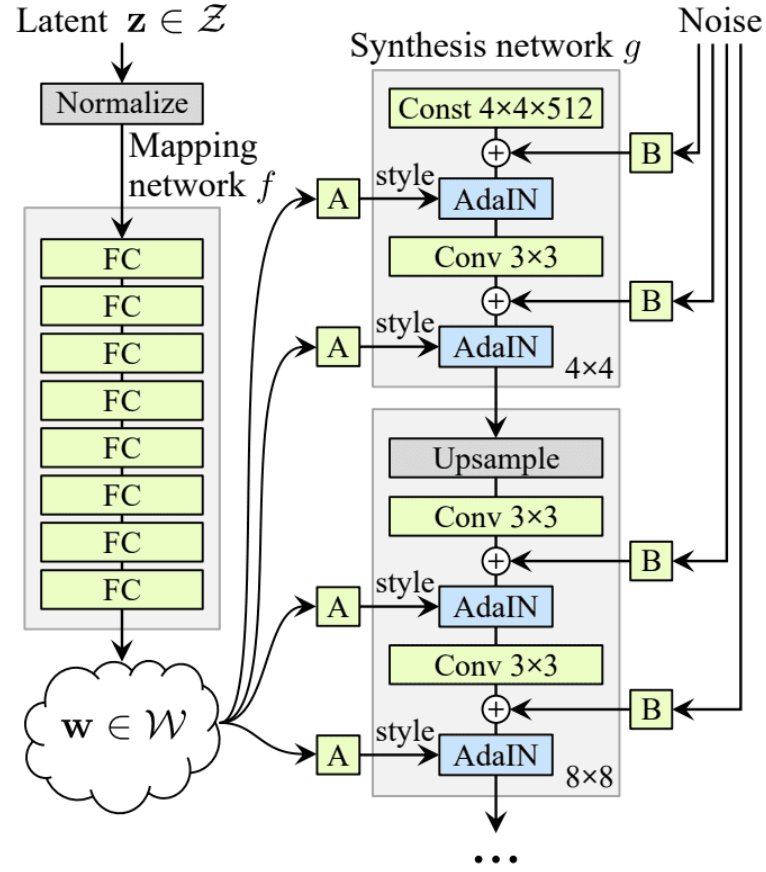

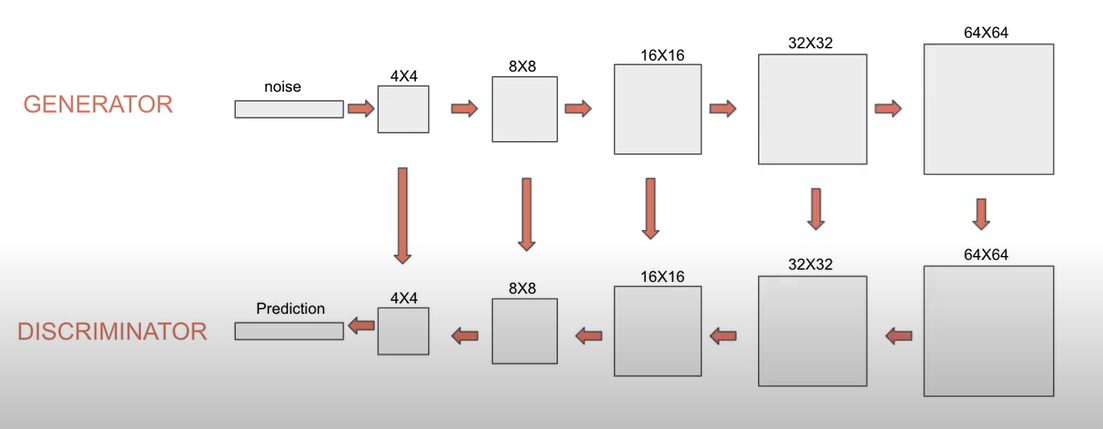

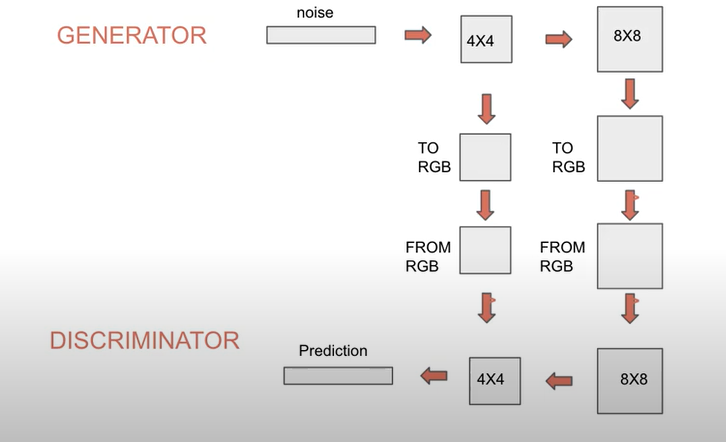

https://arxiv.org/pdf/1812.04948.pdf

https://www.kaggle.com/datasets/splcher/animefacedataset

In [6]:
def rescale_image(im, scale):
    return st.resize(im, (scale, scale))


def chain(*iterables):
    """can be used to unite two generators"""
    for it in iterables:
        for element in it:
            yield element


def wasserstein_loss(y_true, y_pred):
    return torch.mean(y_true * y_pred.squeeze())


def merge_images_and_predict(fake, real, d, scale, batch_size=32):
    a = torch.rand((BATCH_SIZE, 1, 1, 1)).float().to(device)
    mean_images = real * a + fake * (1 - a)
    y_pred = d(mean_images, scale).squeeze()
    return mean_images, y_pred


def gradiant_panelty(mean_images, y_pred):
    ones = torch.ones_like(y_pred)
    grad_params = torch.autograd.grad(
        outputs=y_pred, inputs=mean_images, create_graph=True, grad_outputs=ones
    )[0]
    grad_params = grad_params.reshape(grad_params.shape[0], -1)
    gradient_norm = grad_params.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, scale):
        self.data = data
        self.scale = scale

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, i):
        im = self.data[i, :, :, :]
        im = st.resize(im, (self.scale, self.scale))
        im = im.swapaxes(0, 2)
        return im


def get_loader(img_size, images):

    dataset = Dataset(images, img_size)
    loader = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True
    )
    return loader, dataset

In [7]:
class GenConvBlock(nn.Module):
    def __init__(self, in_c, out_c, hidden_c, do_scale=True):
        super(GenConvBlock, self).__init__()
        self.do_scale = do_scale
        self.out_c = out_c
        self.hidden_c = hidden_c
        self.conv1 = nn.Conv2d(in_c, hidden_c, 3, 1, 1)
        self.conv2 = nn.Conv2d(hidden_c, out_c, 3, 1, 1)
        self.selu = nn.SELU()
        self.gen_noise = torch.randn_like
        self.upsample = F.interpolate
        self.z_2_w = nn.Sequential(
            *([nn.Linear(265, 265)] + [nn.Linear(265, 265) for i in range(6)])
        )
        self.y_scale0 = nn.Linear(265, hidden_c)
        self.y_scale1 = nn.Linear(265, out_c)
        self.y_shift0 = nn.Linear(265, hidden_c)
        self.y_shift1 = nn.Linear(265, out_c)
        self.noise_factor = 0.01

    def forward(self, x):

        x = self.upsample(x, scale_factor=2) if self.do_scale else x
        x = self.selu(self.conv1(x))
        noise = self.gen_noise(x).to(device)
        x = x + noise * self.noise_factor
        x = self.AdaIN(x, 0)
        x = self.selu(self.conv2(x))
        noise = self.gen_noise(x).to(device)
        x = x + noise * self.noise_factor
        x = self.AdaIN(x, 1)
        return x

    def AdaIN(self, x, iter, ys=None):
        ys = torch.randn((x.shape[0], 265)).to(device) if ys is None else ys
        for layer in range(7):
            ys = self.z_2_w[layer](ys)
            ys = self.selu(ys)
        if iter == 0:
            y_scale = self.y_scale0(ys)
            y_shift = self.y_shift0(ys)
        else:
            y_scale = self.y_scale1(ys)
            y_shift = self.y_shift1(ys)
        y_scale = y_scale.view((x.shape[0], x.shape[1], 1, 1))
        y_shift = y_shift.view((x.shape[0], x.shape[1], 1, 1))
        mean = torch.mean(x, dim=[2, 3]).view((x.shape[0], x.shape[1], 1, 1))
        sigma = torch.std(x, dim=[2, 3]).view((x.shape[0], x.shape[1], 1, 1))
        x = (x - mean) / sigma
        x = x * y_scale + y_shift
        return x


# des conv block
class DesConvBlock(nn.Module):
    def __init__(self, in_c, out_c, hidden_c, use_in=True):
        super(DesConvBlock, self).__init__()
        self.use_in = use_in
        self.conv1 = nn.Conv2d(in_c, hidden_c, 3, 1, 1)
        self.conv2 = nn.Conv2d(hidden_c, out_c, 3, 1, 1)
        self.selu = nn.SELU()
        self.downsample = nn.MaxPool2d(2)
        self.adain1 = nn.InstanceNorm2d(hidden_c, affine=True)
        self.adain2 = nn.InstanceNorm2d(out_c, affine=True)

    def forward(self, x):

        x = self.selu(self.conv1(x))
        x = self.adain1(x) if self.use_in else x
        x = self.downsample(x)
        x = self.conv2(x)
        x = self.selu(x)
        x = self.adain2(x) if self.use_in else x
        return x


# generator
class Generator(nn.Module):
    def __init__(self, batch_size):
        super(Generator, self).__init__()
        self.batch_size = batch_size
        self.conv_blocks = nn.ModuleList(
            [
                GenConvBlock(265, 265, 265, do_scale=False),
                GenConvBlock(265, 265, 265),
                GenConvBlock(265, 265, 265),
                GenConvBlock(265, 265, 265),
                GenConvBlock(265, 265, 265),
            ]
        )
        self.rgb_layers = nn.ModuleList(
            [
                nn.Conv2d(265, 3, 1, 1, 0),
                nn.Conv2d(265, 3, 1, 1, 0),
                nn.Conv2d(265, 3, 1, 1, 0),
                nn.Conv2d(265, 3, 1, 1, 0),
                nn.Conv2d(265, 3, 1, 1, 0),
            ]
        )
        self.inital_value = nn.Parameter(torch.randn(1, 265, 4, 4))

    def forward(self, to_scale):
        num_steps = int(log2(to_scale) - 1)
        iv = self.inital_value.repeat(self.batch_size, 1, 1, 1)
        value = torch.clone(iv).float().to(device)
        for step in range(num_steps):
            value = self.conv_blocks[step](value)
        output = self.rgb_layers[num_steps - 1](value)
        return output


# discriminator
class Descirimator(nn.Module):
    def __init__(self):
        super(Descirimator, self).__init__()
        self.conv_blocks = nn.ModuleList(
            [DesConvBlock(265, 265, 265, use_in=False)]
            + [DesConvBlock(265, 265, 265)] * 4
        )
        self.rgb_layers = nn.ModuleList([nn.Conv2d(3, 265, 1, 1, 0)] * 5)
        self.downsample = nn.MaxPool2d(2)
        self.final_conv = nn.Conv2d(265, 1, 1, 1, 0)

    def forward(self, x, from_scale):
        num_steps = int(log2(from_scale) - 1)
        value = self.rgb_layers[num_steps - 2](x)
        for step in range(num_steps):
            value = self.conv_blocks[step](value)
        value = self.downsample(value)
        value = self.final_conv(value)
        return value

In [8]:
def train(scale, lr=0.0001, train_whole=False, e=0, b=0):
    g.train()
    d.train()
    loader, dataset = get_loader(scale, images)
    step = int(log2(scale) - 2)
    g_params = chain(g.conv_blocks[step].parameters(), g.rgb_layers[step].parameters())
    if scale == 4:
        data_iter = iter([g.inital_value])
        g_params = chain(g_params, data_iter)
    if train_whole:
        g_params = g.parameters()
    opt_g = optim.Adam(g_params, lr=lr, betas=(0.0, 0.99))
    opt_d = optim.Adam(d.parameters(), lr=lr, betas=(0.0, 0.99))
    loop = tqdm(loader, leave=True)
    y_true = torch.ones(BATCH_SIZE * 2).to(device)
    y_true[:BATCH_SIZE] *= -1

    for batch_idx, real in enumerate(loop):
        b += 1
        if batch_idx % 30 == 0 and batch_idx > 0:
            clear_output(wait=True)
            plt.imshow(fake[0, :, :, :].swapaxes(0, 2).cpu().detach().numpy())
            plt.axis("off")
            plt.title(f"apoch: {e}, batches:{b}")
            plt.show()
        real = real.float().to(device)

        # train discriminator
        if batch_idx % 5 != 0 or batch_idx == 0:
            fake = g(scale)
            d_real = d(real, scale)
            d_fake = d(fake.detach(), scale)
            mean_images, y_pred = merge_images_and_predict(
                fake, real, d, scale, batch_size=32
            )
            gp = gradiant_panelty(mean_images, y_pred)
            predictions = torch.cat([d_fake, d_real])
            w_loss = wasserstein_loss(y_true, predictions)
            loss = w_loss + LAMBDA_GP * gp
            opt_d.zero_grad()
            loss.backward()
            opt_d.step()

        else:
            # train generator
            fake = g(scale)
            y_pred = d(fake, scale)
            loss = wasserstein_loss(torch.ones(BATCH_SIZE).to(device), y_pred)
            opt_g.zero_grad()
            loss.backward()
            opt_g.step()
    return b

In [9]:
BATCH_SIZE = 32
LAMBDA_GP = 10
g = Generator(BATCH_SIZE).to(device)
d = Descirimator().to(device)

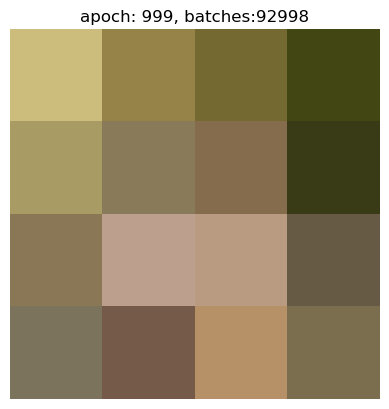

100%|██████████| 93/93 [00:03<00:00, 29.27it/s]


In [ ]:
b = 0
for i in range(1000):
    b = train(4, e=i, b=b)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


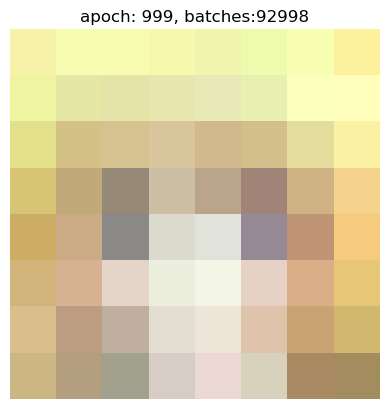

100%|██████████| 93/93 [00:04<00:00, 22.55it/s]


In [ ]:
b = 0
for i in range(1000):
    b = train(8, e=i, b=b)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


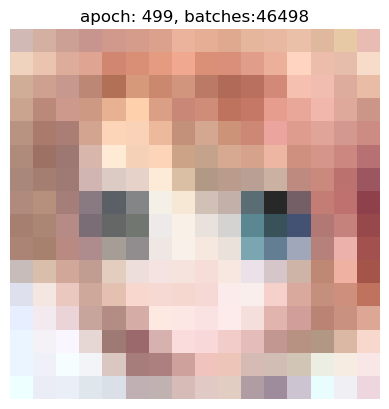

100%|██████████| 93/93 [00:09<00:00,  9.45it/s]


In [ ]:
b = 0
for i in range(500):
    b = train(16, e=i, b=b)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


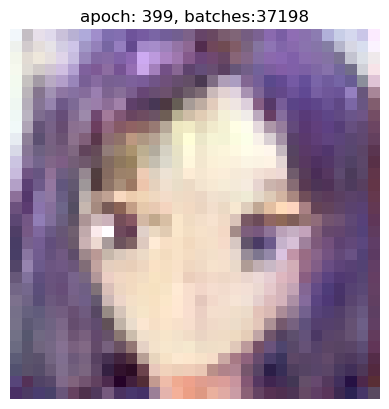

100%|██████████| 93/93 [00:34<00:00,  2.70it/s]


In [ ]:
b = 0
for i in range(400):
    b = train(32, e=i, b=b)
    if i % 50 == 0:
        torch.save(g.state_dict(), "generator.pth")
        torch.save(d.state_dict(), "discriminator.pth")

In [ ]:
# #save model
# torch.save(g.state_dict(), "generator.pth")
# torch.save(d.state_dict(), "discriminator.pth")

In [10]:
g = Generator(BATCH_SIZE).to(device)
d = Descirimator().to(device)
g.load_state_dict(torch.load("generator.pth"))
d.load_state_dict(torch.load("discriminator.pth"))

<All keys matched successfully>

In [11]:
!nvidia-smi

Wed May  3 20:24:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    25W /  70W |    711MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

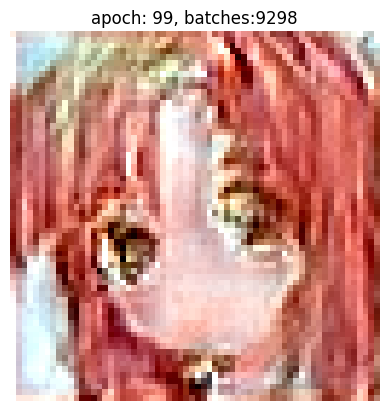

100%|██████████| 93/93 [01:20<00:00,  1.16it/s]


In [12]:
b = 0
for i in range(100):
    b = train(64, e=i, b=b)
    if i % 10 == 0:
        torch.save(g.state_dict(), "generator.pth")
        torch.save(d.state_dict(), "discriminator.pth")

In [13]:
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
logger.setLevel(old_level)
g.eval()
d.eval()


def show_scale_examples(scale):
    out = g(scale)
    c = 0
    f, a = plt.subplots(4, 4, figsize=(18, 10))
    f.tight_layout(pad=0.1)
    for row in range(2):
        for col in range(4):
            im = out[c, :, :, :].swapaxes(0, 2).cpu().detach().numpy()
            c += 1
            a[row, col].imshow(im)
            a[row, col].axis("off")
    for row in range(2, 4):
        for col in range(4):
            c = np.random.randint(images.shape[0])
            im = st.resize(images[c, :, :, :], (scale, scale))
            a[row, col].imshow(im)
            a[row, col].axis("off")

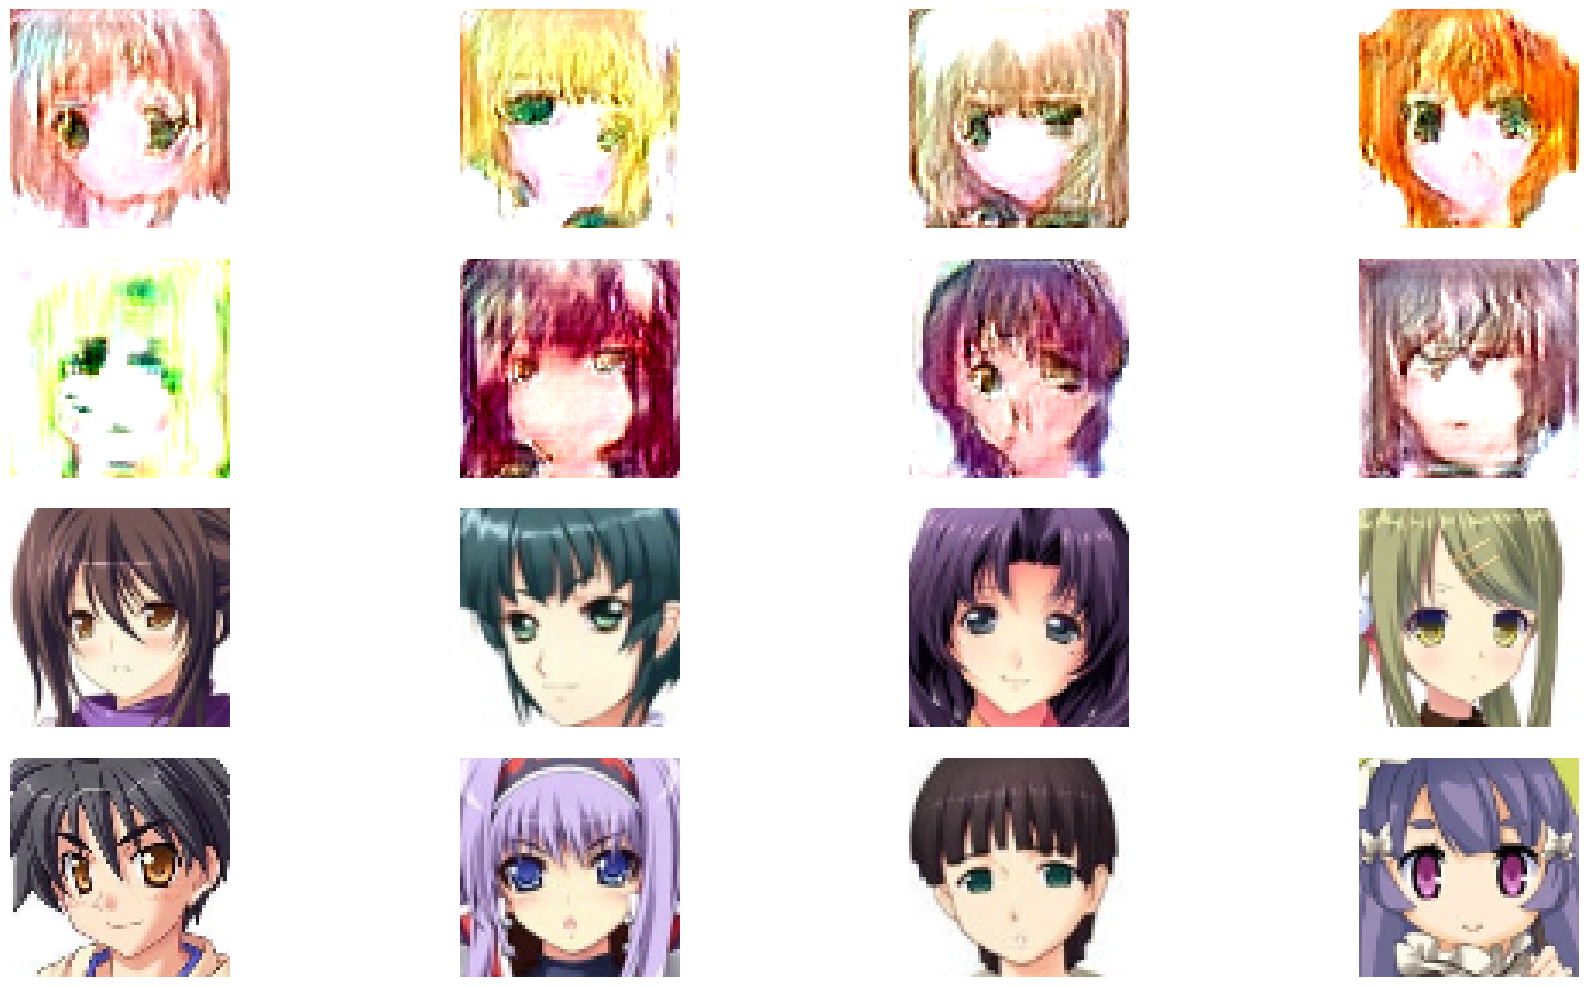

In [14]:
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
show_scale_examples(64)
logger.setLevel(old_level)

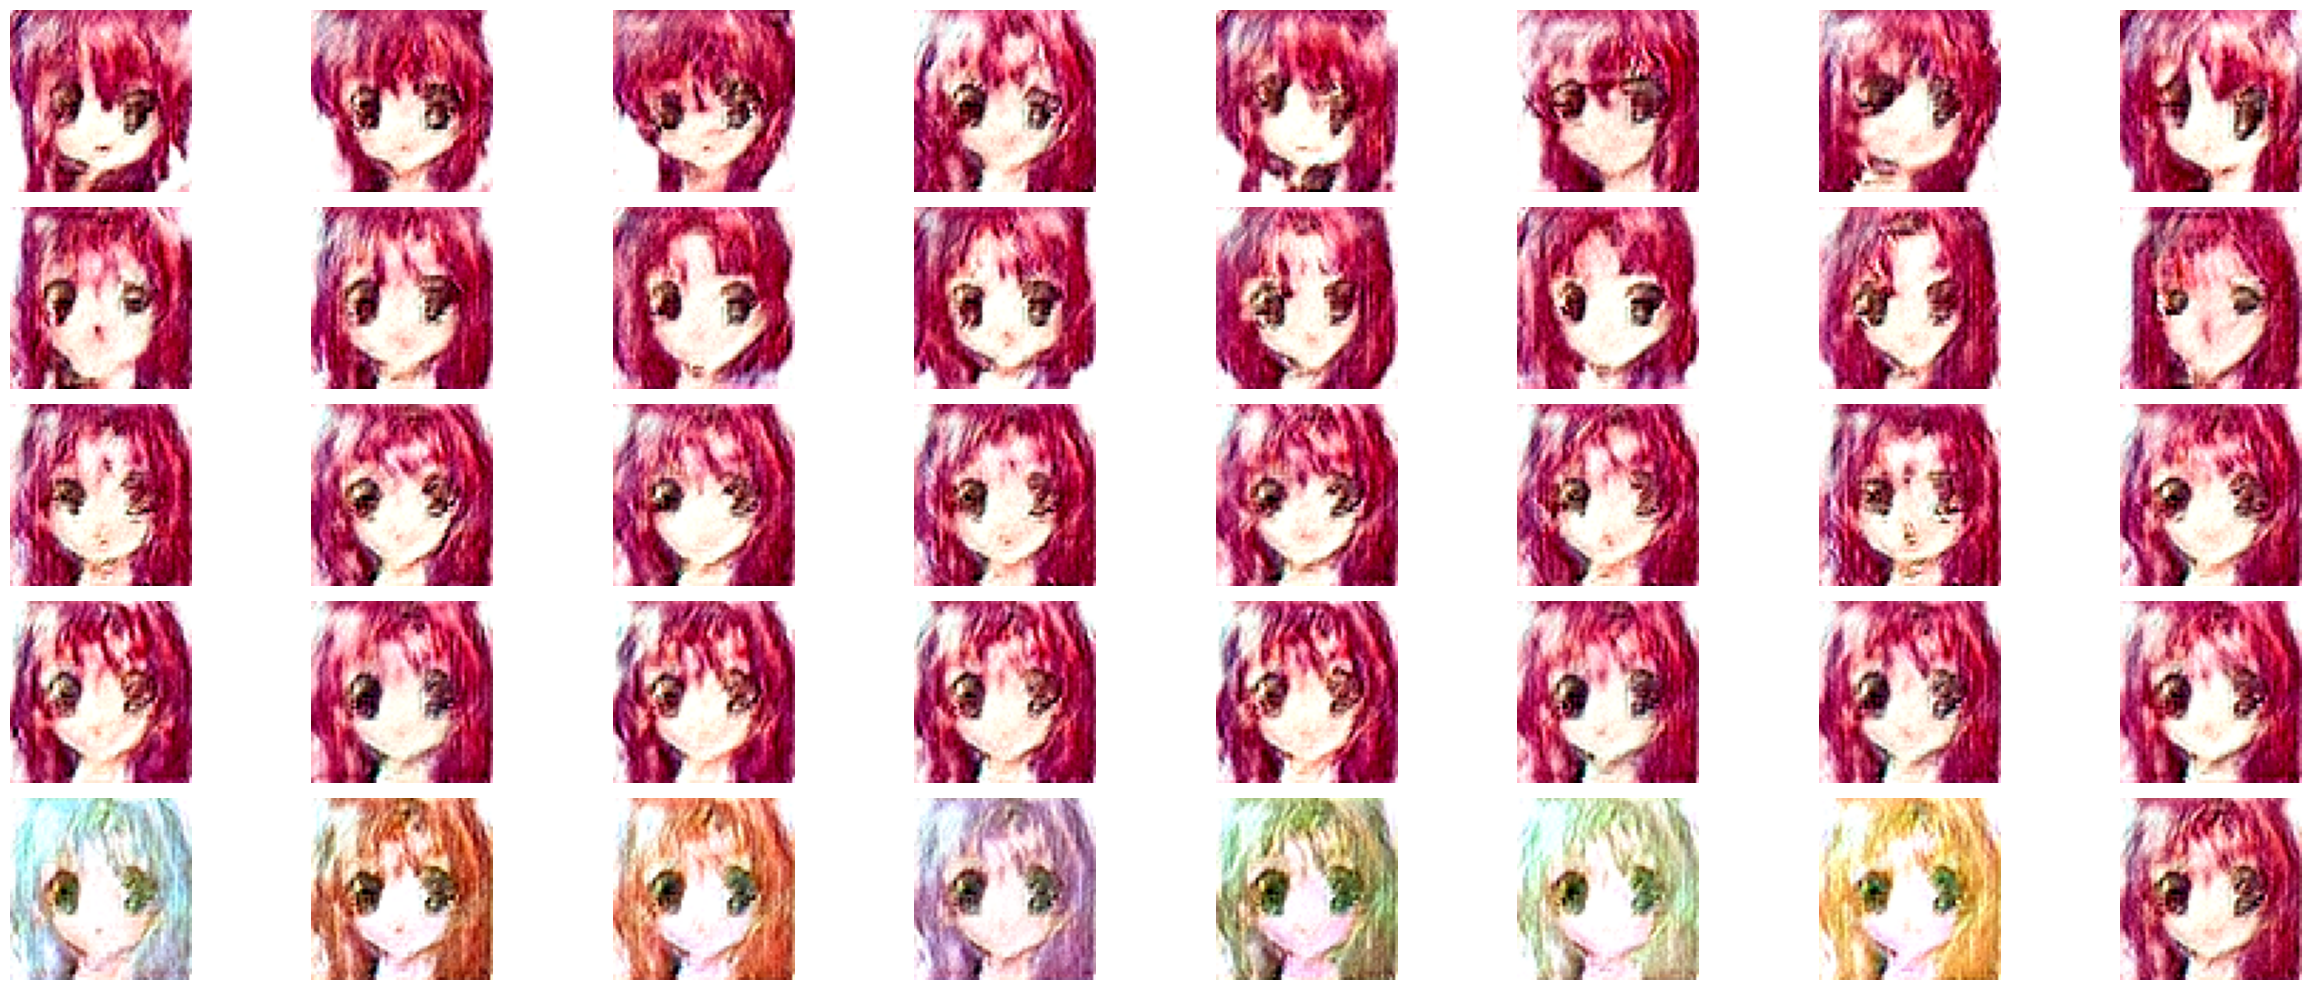

In [16]:
ys = torch.randn((1, 265)).to(device)
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

f, a = plt.subplots(5, 8, figsize=(25, 10))
for r in range(5):
    for c in range(8):
        change = r
        g.eval()
        for i in range(5):
            if i == 0:
                val = F.selu(g.conv_blocks[i].conv1(g.inital_value))
            else:
                val = F.interpolate(val, scale_factor=2)
                val = F.selu(g.conv_blocks[i].conv1(val))
            noise = torch.randn_like(val)  # .to(device)
            val = val + noise * 0.03
            if i == change:
                ys_new = torch.randn((1, 265)).to(device)
                val = g.conv_blocks[i].AdaIN(val, 0, ys=ys_new)
            else:
                val = g.conv_blocks[i].AdaIN(val, 0, ys=ys)
            val = F.selu(g.conv_blocks[i].conv2(val))
            noise = torch.randn_like(val)
            val = val + noise * 0.03
            if i == change:
                ys_new = torch.randn((1, 265)).to(device)
                val = g.conv_blocks[i].AdaIN(val, 1, ys=ys_new)
            else:
                val = g.conv_blocks[i].AdaIN(val, 1, ys=ys)
        result = g.rgb_layers[4](val)
        im = result[0, :, :].swapaxes(0, 2).cpu().detach().numpy()
        a[r, c].axis("off")
        a[r, c].imshow(im)
f.tight_layout()
logger.setLevel(old_level)